In [1]:
import os 
from pathlib import Path

project_root = Path.cwd().parents[0]
os.chdir(project_root)
print("Set project_root:", project_root)

Set project_root: /home/sromo/Repos/lm-testbed


In [ ]:
import torch
from src.architectures.GPT2 import GPTModel
from src.configs.GPT2 import GPT_CONFIG_124M

GPT_CONFIG_124M = GPT_CONFIG_124M.copy()
GPT_CONFIG_124M["context_length"] = 256 # Reduce context length to reduce computational demands

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [3]:
import tiktoken
from src.utils.generate import generate_text_simple

def text_to_token_ids(text:str, tokenizer:tiktoken.core.Encoding):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)         # Adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids:torch.Tensor, tokenizer:tiktoken.core.Encoding):
    flat = token_ids.squeeze(0)     # Removes the batch dimension
    decoded = tokenizer.decode(flat.tolist())
    return decoded

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Model input:\n", text_to_token_ids(start_context, tokenizer))
print("\nModel output:\n", token_ids)
print("\nOutput text:\n", token_ids_to_text(token_ids, tokenizer))

Model input:
 tensor([[6109, 3626, 6100,  345]])

Model output:
 tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


**Calculating the text generation loss**

In [4]:
inputs = torch.tensor([[16833,  3626,  6100],     # ["every effort moves",
                       [40,     1107,   588]])    # "I really like"]

targets = torch.tensor([[3626, 6100, 345],        # [" effort moves you",
                        [  40, 1107, 588]])       #  " really like chocolate"]

with torch.no_grad():    # Disable gradient tracking since we are not training yet
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  # (batch_size, n_tokens, emb_dim)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("\nOutput token IDs:\n", token_ids)

print(f"\nTargets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print("           ",targets[0])
print(f"\nOutputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
print(f"        ",token_ids[0].squeeze(1))

torch.Size([2, 3, 50257])

Output token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

Targets batch 1:  effort moves you
            tensor([3626, 6100,  345])

Outputs batch 1:  Armed heNetflix
         tensor([16657,   339, 42826])


In [5]:
# Probability scores for each target
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]   # (batch, n_tokens, emb_dim) - Probability for the CORRECT next tokens
print("Text 1:\n", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("\nText 2:\n", target_probas_2)

Text 1:
 tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])

Text 2:
 tensor([4.2743e-05, 2.5524e-05, 2.1971e-05])


**Calculating the loss of for the probability scores**

In [6]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2))) # Concatenate to allow torch.log and torch.mean operate on the entire predictions simultaneously
print("log_probas:\n", log_probas)

log_probas:
 tensor([ -9.5042, -10.3796, -11.3677, -10.0603, -10.5759, -10.7258])


In [7]:
avg_log_probas = torch.mean(log_probas)
print("avg_log_probas:\n", avg_log_probas)

avg_log_probas:
 tensor(-10.4356)


In [8]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.4356)


**Pytorch's cross entropy function**

In [9]:
# Recall
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [10]:
# For the cross_entropy loss function in PyTorch we need to flatten these tensors by combining them over the batch dimension
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print("Flattened logits:\n", logits_flat.shape)
print("\nFlattened targets:\n", targets_flat.shape)

Flattened logits:
 torch.Size([6, 50257])

Flattened targets:
 torch.Size([6])


In [11]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.4356)


In [12]:
# Perplexity measures how well the model matches the distribution of words in the dataset. Analogous to the vocabulary size the model is uncertain at each step

perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(34049.6641)


**Calculating the training and validation set losses**

In [13]:
# Load the data
file_path = project_root / "data" / "raw" / "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens:", total_tokens)

Characters:  20479
Tokens: 5145


In [14]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [15]:
from src.dataloaders.GPT import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

print("Train loader (x-input data, y-target data):")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader: (x-input data, y-target data)")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader (x-input data, y-target data):
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader: (x-input data, y-target data)
torch.Size([2, 256]) torch.Size([2, 256])


In [16]:
def calc_loss_batch(input_batch:torch.Tensor, target_batch:torch.Tensor, model:torch.nn.Module, device:torch.device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches:int = None):
    """ Returns the average loss across all batches in a data loader"""
    total_loss = 0
    if len(data_loader) == 0:
        return float ("nan")
    elif num_batches is None:
        num_batches = len(data_loader)      # Itereatives over all batches if no fixed num_batches specified
    else:
        num_batches = min(num_batches, len(data_loader)) # Reduces num_batches to match the total number of batches in the data loader if num_batches exceeds ir

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

    

In [17]:
 # USAGE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():       # Disable gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:\n", train_loss)
print("\nValidation loss:\n", val_loss)

Training loss:
 10.987583372328016

Validation loss:
 10.981104850769043


**Training an LLM**

In [18]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import tiktoken

from src.loss.cross_entropy import calc_loss_batch, calc_loss_loader
from src.utils.token_converter import text_to_token_ids, token_ids_to_text
from src.utils.generate import generate_text_simple


def generate_and_print_sample(model:nn.Module, tokenizer:tiktoken.core.Encoding, device:torch.device, start_context:str):
    """
    Given a start context, generate text using a language model.

    Parameters
    ----------
    model (nn.Module):
        Language model.
    tokenizer (tiktoken.core.Encoding):
        Model tokenizer.
    device (troch.device):
        Device to generate in.
    start_context (str)
        Text to serve as start context for the model.

    Returns
    -------
    None
    """
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, 
            max_new_tokens=50, context_size=context_size
            )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def evaluate_model(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, device:torch.device, eval_iter:int):
    """
    Calculate model training and validation losses.

    Parameters
    ----------
    model (nn.Module):
        Language model.
    train_loader (DataLoader):
        DataLoader with training data.
    val_loader (DataLoader):
        Dataloader with validation data.
    device (torch.device):
        Device to procees training and validation data.
    eval_iter (int):
        Number of batches to calculate the loss on.

    Returns
    -------
    train_loss (float):
        Average training loss across batches.
    val_loss (float):
        Average validation loss across batches.
    """
    model.eval()    # Disable dropout during evaluation for stable, reproducible results
    with torch.no_grad():   # Disable gradient tracking to reduce computational overhead
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_model_simple(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, 
                       optimizer, device:torch.device, num_epochs:int, 
                       eval_freq:int, eval_iter:int, start_context:str, tokenizer:tiktoken.core.Encoding):
    """
    Simple model training function for a language model. 

    Parameters
    ----------
    model (nn.Module):
        Language model.
    train_loader (DataLoader):
        DataLoader with training data.
    val_loader (DataLoader):
        Dataloader with validation data.
    optimizer (torch.optim):
        Optimizer used for training.
    device (torch.device):
        Device to procees training and validation data.
    num_epochs (int):
        Number of epochs to train the model for.
    eval_freq (int):
        Epoch frequency in which to evaluate the model.
    eval_iter (int):
        Number of batches to calculate the loss on.
    start_context (str)
        Text to serve as start context for the model.
    tokenizer (tiktoken.core.Encoding):
        Model tokenizer.    
    """
    train_losses, val_losses, track_tokens_seen = [], [], []        # Initialize lists to track losses and tokens seen
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()       # Resets loss gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()             # Calculates loss gradients
            optimizer.step()            # Updates model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f}, "
                      f"Val loss: {val_loss:.3f}"
                )
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [19]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss: 9.825, Val loss: 9.931
Ep 1 (Step 000005): Train loss: 8.069, Val loss: 8.341
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss: 6.625, Val loss: 7.051
Ep 2 (Step 000015): Train loss: 6.048, Val loss: 6.599
Every effort moves you, and,, and,,,,,,,,,.                                   
Ep 3 (Step 000020): Train loss: 5.574, Val loss: 6.494
Ep 3 (Step 000025): Train loss: 5.504, Val loss: 6.413
Every effort moves you, and, and, and, and, and, and, and of the of the of the of the to to to the to to the of the of the of the of the of the's, and, and, and, and, and
Ep 4 (Step 000030): Train loss: 5.078, Val loss: 6.322
Ep 4 (Step 000035): Train loss: 4.836, Val loss: 6.315
Every effort moves you a the picture. I had been the picture-- the picture. Gisburn. I had been, and the of the of the of the the of the of the picture. I had the of the of the of the of the of the of
Ep 5 (Step 000040): Train loss: 4.22

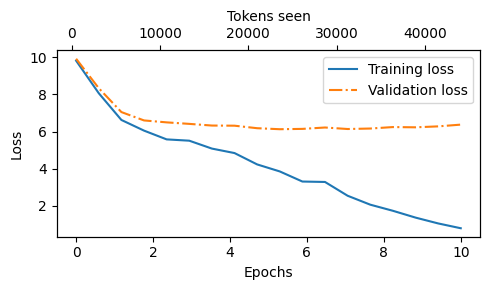

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

**Decoding strategies to control randomness**

In [21]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [22]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




**Temperature Scaling**

Adds a probabilistic selection process to the next-token generation task

In [23]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [24]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
#                                 every effort moves you
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])


forward


In [25]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
#                                 every effort moves you
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.multinomial(probas, num_samples=1).item()         # Sample tokens proportional to their probability score
print(inverse_vocab[next_token_id])

toward


In [26]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [27]:
# Temperature scaling divides the logits by the temperature value
# Temperature > 1 --> more uniformly distributed token probabilities
# Temperature < 1 --> more confident (sharper, peaky) distributions

# Temperature = 1 is equivalent to NOT using temperature scaling

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

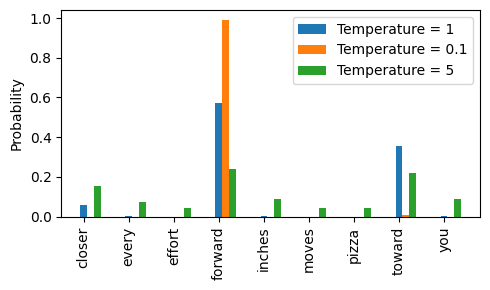

In [28]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
# How often is pizza sampled?
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        if inverse_vocab[i] == "pizza":
            print(f"{100*freq/1_000:.1f}% x {inverse_vocab[i]}")

for i, sp in enumerate(scaled_probas):
    print("Temperature:", temperatures[i])
    print_sampled_tokens(sp)
    print("\n")


Temperature: 1
0.0% x pizza


Temperature: 0.1
0.0% x pizza


Temperature: 5
4.3% x pizza




In [30]:
# We can also calculate directly from the scaled probabilities
for i, sp in enumerate(scaled_probas):
    print("Temperature:", temperatures[i])
    pizza_scaled_probas = sp[6].item()
    print(f"{pizza_scaled_probas*100:.1f}% x pizza")
    print("\n")

Temperature: 1
0.0% x pizza


Temperature: 0.1
0.0% x pizza


Temperature: 5
4.3% x pizza




**Top-K sampling**

In [31]:
print(next_token_logits)

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])


In [32]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [33]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [34]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


**Modifying the text generation function - adding Temperature, and Top-K**

In [35]:
from src.utils.generate import generate

torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, one himself it was no my dear; and


**Loading and saving model weights in PyTorch**

In [36]:
model.state_dict()

OrderedDict([('tok_emb.weight',
              tensor([[ 3.4805e-01, -1.7814e-01, -3.0609e-01,  ..., -3.2803e-01,
                       -1.3868e+00,  5.3282e-01],
                      [ 2.6043e-01,  3.4480e-01, -8.1792e-01,  ..., -4.0677e-01,
                        4.9907e-01, -3.7965e-01],
                      [ 7.9288e-01,  5.3309e-01,  9.3936e-01,  ..., -1.0710e+00,
                        9.5149e-02, -1.4087e+00],
                      ...,
                      [-7.1022e-01, -5.0010e-01,  1.4068e+00,  ..., -1.4925e-01,
                       -4.8801e-01, -1.0582e+00],
                      [ 2.0572e+00,  1.1150e+00,  3.8348e-01,  ..., -7.1757e-01,
                       -5.5503e-01,  9.8285e-01],
                      [ 1.1323e-03, -7.5050e-01, -1.7859e-01,  ..., -3.2327e-01,
                        2.5962e-01,  5.8674e-01]])),
             ('pos_emb.weight',
              tensor([[ 0.8780,  0.2499,  0.8413,  ..., -1.0324,  1.3025,  1.7889],
                      [-1.0033,  0.0

In [39]:
%%script echo SKIPPED
# Saving model parameters via state_dict()
out_path = project_root / "data" / "model_parameters"/ "GPT2_124M" / "model.pth"
out_path.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), out_path)

SKIPPED


In [40]:
out_path = project_root / "data" / "model_parameters"/ "GPT2_124M" / "model.pth"

# Loading model parameters from state_dict
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load(out_path, map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [41]:
%%script echo SKIPPED

# Saving Parameters AND optimizer state
out_path = project_root / "data" / "model_parameters" / "GPT2_124M" / "model_and_optimizer.pth"
out_path.mkdir(parents=True, exist_ok=True)

torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    out_path
)

SKIPPED


In [42]:
out_path = project_root / "data" / "model_parameters" / "GPT2_124M" / "model_and_optimizer.pth"

# Loading Parameters AND optimizer state
checkpoint = torch.load(out_path, map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();